In [142]:
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2
from scipy.stats.kde import gaussian_kde
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import logging
import imp
imp.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [143]:
class MnistData():
    def __init__(self, batch_size=32, image_size=[64, 32], orig_image_size=64):
        self.name = 'mnist'
        self.load_mnist()
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        logging.info('number of training image: %d, number of testing image: %d', self.train_images.shape[0], 
                     self.test_images.shape[0])
    
    def load_mnist(self, file_name='/home/yi/code/video_motion_mnist/mnist.h5'):
        f = h5py.File(file_name)
        train_images = f['train'].value.reshape(-1, 28, 28)
        self.train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), 'constant')
        self.train_labels = f['train_labels'].value
        test_images = f['test'].value.reshape(-1, 28, 28)
        self.test_images = np.pad(test_images, ((0, 0), (2, 2), (2, 2)), 'constant')
        self.test_labels = f['test_labels'].value
    
    def get_next_batch(self, status='train'):
        batch_size, im_size, orig_im_size = self.batch_size, self.im_size, self.orig_im_size
        im = []
        for i in range(len(im_size)):
            im.append(np.zeros((batch_size, im_size[i], im_size[i], 1)))
        orig_im = np.zeros((batch_size, orig_im_size, orig_im_size, 1))
        # orig_im = np.random.rand(batch_size, orig_im_size, orig_im_size, 1) * 0.5
        direction = np.zeros((batch_size, 3))
        boxes = np.zeros((batch_size, 4))
        label = np.zeros(batch_size)
        
        if status == 'train':
            images = self.train_images
            labels = self.train_labels
        else:
            images = self.test_images
            labels = self.test_labels
        idx = np.random.permutation(images.shape[0])
        mnist_im = images[idx[0:batch_size], :, :]
        mnist_label = labels[idx[0:batch_size]]
        for i in range(batch_size):
            x = np.random.rand()
            y = np.random.rand()
            s = np.random.rand()
            direction[i, 0] = x
            direction[i, 1] = y
            direction[i, 2] = s
            s = int((s + 0.5) / 2 * orig_im_size)
            x = int(x * (orig_im_size - s))
            y = int(y * (orig_im_size - s))
            resized_im = cv2.resize(mnist_im[i, :, :], (s, s), interpolation=cv2.INTER_AREA)
            orig_im[i, y:y+s, x:x+s, 0] = resized_im
            boxes[i, 0] = x
            boxes[i, 1] = y
            boxes[i, 2] = x + s
            boxes[i, 3] = y + s
            label[i] = mnist_label[i]
            for j in range(len(im_size)):
                im[j][i, :, :, 0] = cv2.resize(orig_im[i, :, :, 0], (im_size[j], im_size[j]), interpolation=cv2.INTER_AREA)
        orig_im = orig_im.transpose((0, 3, 1, 2))
        for i in range(len(im_size)):
            im[i] = im[i].transpose((0, 3, 1, 2))
        boxes = boxes * 1.0 / orig_im_size
        return im, orig_im, boxes, direction, label
    
    def display(self, im, orig_im, box, direction, label):
        print(direction[0, :], label[0])
        # Plot original large image with bounding box
        orig_im = orig_im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im, cmap='gray')
        
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        print b
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
        # Plot resized image with bounding box
        for im_s in im:
            im_s = im_s[0, 0, :, :]
            fig, ax = plt.subplots(1)
            ax.imshow(im_s, cmap='gray')
        
        plt.show()

04:02:55 INFO:number of training image: 50000, number of testing image: 10000


(array([0.53295828, 0.98037894, 0.5432539 ]), 6.0)
[16. 30. 49. 63.]


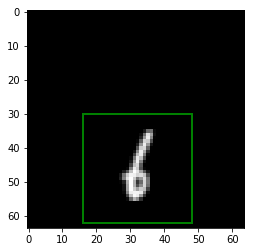

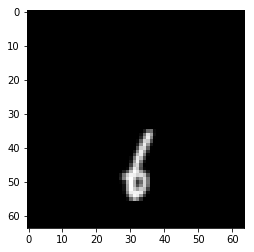

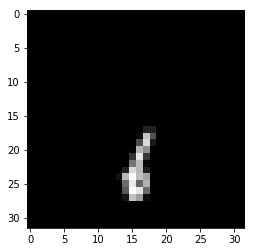

(array([0.57136405, 0.01941656, 0.24679013]), 9.0)
[23.  0. 46. 23.]


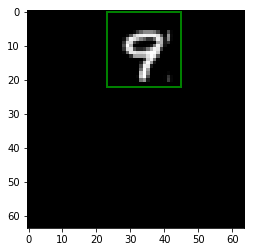

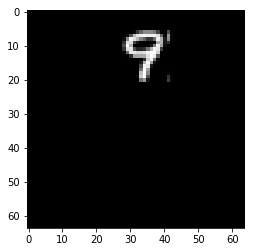

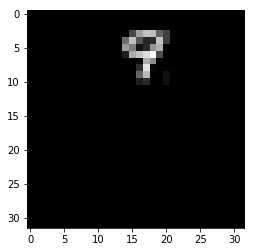

In [144]:
data = MnistData()
im, orig_im, box, direction, label = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

In [145]:
class BaseAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attn_image_size, image_channel, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by image only demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_im_size = attn_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseAttnNet(self.batch_size, self.im_size, self.attn_im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i).float()) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im = [i.cuda() for i in im]
            orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(im, display)

In [146]:
class BaseAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_im_size, im_channel, n_class):
        super(BaseAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv_i = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_i = nn.BatchNorm2d(num_hidden*16)
        self.conv_a = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_a = nn.BatchNorm2d(num_hidden*16)
        self.conv_attn = nn.Conv2d(num_hidden*16, 1, 1, 1, 0)
        self.fc = nn.Linear(num_hidden*16, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_im_size = attn_im_size

    def soft_attn(self, x):
        attn_size = []
        for i in range(len(x)):
            attn_size.append([x[i].size(2), x[i].size(3)])
            x[i] = self.conv_attn(x[i])
            x[i] = x[i].view(x[i].size(0), -1)
        x_a = torch.cat(x, 1)
        attn = F.softmax(x_a, 1)
        attn_maps, cnt = [], 0
        for i in range(len(x)):
            a = attn[:, cnt:cnt + attn_size[i][0] * attn_size[i][1]]
            a = a.contiguous().view(-1, attn_size[i][0], attn_size[i][1])
            cnt = cnt + attn_size[i][0] * attn_size[i][1]
            attn_maps.append(a)
        return attn_maps
        
    def attn_pool(self, im_feat, attn_maps):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
            attn_maps[i] = attn_maps[i].view(attn_maps[i].size(0), -1)
        feat = torch.cat(im_feat, 2)
        attn = torch.cat(attn_maps, 1)
        final_feat = torch.sum(feat * attn[:, None, :], 2)
        return final_feat
        
    def forward(self, images, display=False):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x_i = F.relu(self.bn_i(self.conv_i(x5)))
            x_a = F.relu(self.bn_a(self.conv_a(x5)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn_maps = self.soft_attn(attn_feat)
        if display:
            self.visualize_attn(images, attn_maps)
        x = self.attn_pool(im_feat, attn_maps)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def visualize_attn(self, images, attn_maps):
        num_image = len(images)
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size))
        max_attn_size, sum_attn_size = 0, 0
        for attn in attn_maps:
            max_attn_size = max(max_attn_size, attn.size(1))
            sum_attn_size = sum_attn_size + attn.size(1)
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(num_image):
            im = images[i]
            im = im.cpu().data.numpy()
            im = im[0, 0, :, :]
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i]
            attn = attn.cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
            
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(im_all, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(attn_all)
        plt.show()

03:19:02 INFO:Baseline with bounding box crop estimated by image only demo
03:19:02 INFO:number of training image: 50000, number of testing image: 10000
03:19:02 INFO:epoch 0, train loss: 2.32, average train loss: 2.32
03:19:02 INFO:epoch 0, train accuracy: 0.08, average train accuracy: 0.08
03:19:02 INFO:epoch 1, train loss: 2.19, average train loss: 2.26
03:19:02 INFO:epoch 1, train accuracy: 0.23, average train accuracy: 0.16
03:19:03 INFO:epoch 2, train loss: 2.19, average train loss: 2.24
03:19:03 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.17
03:19:03 INFO:epoch 3, train loss: 2.17, average train loss: 2.22
03:19:03 INFO:epoch 3, train accuracy: 0.22, average train accuracy: 0.18
03:19:03 INFO:epoch 4, train loss: 2.18, average train loss: 2.21
03:19:03 INFO:epoch 4, train accuracy: 0.22, average train accuracy: 0.19
03:19:03 INFO:epoch 5, train loss: 2.23, average train loss: 2.22
03:19:03 INFO:epoch 5, train accuracy: 0.22, average train accuracy: 0.20
03:19:0

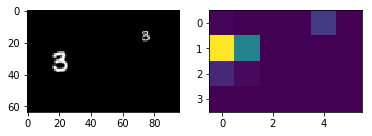

In [130]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [64, 32]
orig_im_size = 64
attn_im_size = 32
im_channel = 1
n_class = 10
tensorboard_path = './tensorboard/mnist_base_soft_attn'
init_model_path = ''
demo = BaseAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                    batch_size, im_size, orig_im_size, attn_im_size, im_channel, n_class, tensorboard_path, 
                    init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

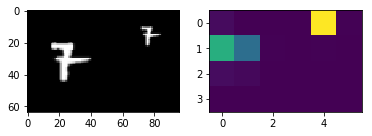

In [132]:
demo.visualize()

In [147]:
class BaseDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attention_size, image_channel, direction_dim, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by direction only demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_size = attention_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseDirectionAttnNet(self.batch_size, self.im_size, self.attn_size, self.im_channel, 
                                          self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i).float()) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im = [i.cuda() for i in im]
            orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(im, direction, display)

In [148]:
class BaseDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_size, im_channel, direction_dim, n_class):
        super(BaseDirectionAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv_i = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_i = nn.BatchNorm2d(num_hidden*16)
        self.conv_a = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_a = nn.BatchNorm2d(num_hidden*16)
        self.conv_attn = nn.Conv2d(num_hidden*16, 1, 1, 1, 0)
        self.fc = nn.Linear(num_hidden*16, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_d = nn.Linear(direction_dim, num_hidden)
        self.bn_d = nn.BatchNorm1d(num_hidden)
        self.fc_attn = nn.Linear(num_hidden, np.sum(np.array(attn_size)**2))
        # self.fc_attn = nn.Linear(direction_dim, np.sum(np.array(attn_size)**2))
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_size = attn_size
        
    def soft_attn(self, direction):
        d0 = self.bn_d0(direction)
        d = F.relu(self.bn_d(self.fc_d(direction)))
        x_d = self.fc_attn(d)
        # x_d = self.fc_attn(direction)
        attn = F.softmax(x_d, 1)
        attn_maps, cnt = [], 0
        for i in range(len(self.attn_size)):
            a = attn[:, cnt:cnt + self.attn_size[i]**2]
            a = a.contiguous().view(-1, self.attn_size[i], self.attn_size[i])
            cnt = cnt + self.attn_size[i]**2
            attn_maps.append(a)
        return attn_maps
        
    def attn_pool(self, im_feat, attn_maps):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
            attn_maps[i] = attn_maps[i].view(attn_maps[i].size(0), -1)
        feat = torch.cat(im_feat, 2)
        attn = torch.cat(attn_maps, 1)
        final_feat = torch.sum(feat * attn[:, None, :], 2)
        return final_feat
        
    def forward(self, images, direction, display=False):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x_i = F.relu(self.bn_i(self.conv_i(x5)))
            x_a = F.relu(self.bn_a(self.conv_a(x5)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn_maps = self.soft_attn(direction)
        if display:
            self.visualize_attn(images, attn_maps)
        x = self.attn_pool(im_feat, attn_maps)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def visualize_attn(self, images, attn_maps):
        num_image = len(images)
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size))
        max_attn_size, sum_attn_size = 0, 0
        for attn in attn_maps:
            max_attn_size = max(max_attn_size, attn.size(1))
            sum_attn_size = sum_attn_size + attn.size(1)
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(num_image):
            im = images[i]
            im = im.cpu().data.numpy()
            im = im[0, 0, :, :]
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i]
            attn = attn.cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
            
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(im_all, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(attn_all)
        plt.show()

04:03:06 INFO:Baseline with bounding box crop estimated by direction only demo
04:03:07 INFO:number of training image: 50000, number of testing image: 10000
04:03:07 INFO:epoch 0, train loss: 2.33, average train loss: 2.33
04:03:07 INFO:epoch 0, train accuracy: 0.09, average train accuracy: 0.09
04:03:07 INFO:epoch 1, train loss: 2.24, average train loss: 2.28
04:03:07 INFO:epoch 1, train accuracy: 0.17, average train accuracy: 0.13
04:03:07 INFO:epoch 2, train loss: 2.18, average train loss: 2.25
04:03:07 INFO:epoch 2, train accuracy: 0.23, average train accuracy: 0.17
04:03:07 INFO:epoch 3, train loss: 2.18, average train loss: 2.23
04:03:07 INFO:epoch 3, train accuracy: 0.19, average train accuracy: 0.17
04:03:07 INFO:epoch 4, train loss: 2.15, average train loss: 2.22
04:03:07 INFO:epoch 4, train accuracy: 0.19, average train accuracy: 0.17
04:03:07 INFO:epoch 5, train loss: 2.14, average train loss: 2.20
04:03:07 INFO:epoch 5, train accuracy: 0.16, average train accuracy: 0.17
04:

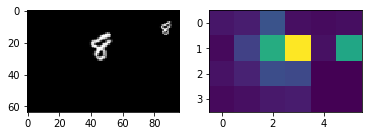

In [149]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [64, 32]
orig_im_size = 64
attn_size = [4, 2]
im_channel = 1
direction_dim = 3
n_class = 10
tensorboard_path = './tensorboard/mnist_base_direction_soft_attn'
init_model_path = ''
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, 
                             save_dir, batch_size, im_size, orig_im_size, attn_size, im_channel, direction_dim, 
                             n_class, tensorboard_path, init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

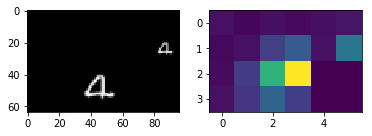

In [152]:
demo.visualize()

In [153]:
class CombDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attention_size, image_channel, direction_dim, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by image and direction together demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_size = attention_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = CombDirectionAttnNet(self.batch_size, self.im_size, self.attn_size, self.im_channel, 
                                          self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i).float()) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im = [i.cuda() for i in im]
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i).float(), volatile=True) for i in im]
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im = [i.cuda() for i in im]
            orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(im, direction, display)

In [138]:
class CombDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_size, im_channel, direction_dim, n_class):
        super(CombDirectionAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv_i = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_i = nn.BatchNorm2d(num_hidden*16)
        self.conv_a = nn.Conv2d(num_hidden*16, num_hidden*16, 3, 1, 1)
        self.bn_a = nn.BatchNorm2d(num_hidden*16)
        self.conv_attn = nn.Conv2d(num_hidden*16, 1, 1, 1, 0)
        self.fc = nn.Linear(num_hidden*16, n_class)
        
        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_d = nn.Linear(direction_dim, num_hidden)
        self.bn_d = nn.BatchNorm1d(num_hidden)
        self.fc_attn = nn.Linear(num_hidden, np.sum(np.array(attn_size)**2))
        # self.fc_attn = nn.Linear(direction_dim, np.sum(np.array(attn_size)**2))
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_size = attn_size
        
    def soft_attn(self, x, direction):
        attn_size = []
        for i in range(len(x)):
            attn_size.append([x[i].size(2), x[i].size(3)])
            x[i] = self.conv_attn(x[i])
            x[i] = x[i].view(x[i].size(0), -1)
        x_a = torch.cat(x, 1)
        
        d0 = self.bn_d0(direction)
        d = F.relu(self.bn_d(self.fc_d(direction)))
        x_d = self.fc_attn(d)
        # attn = self.fc_attn(direction)
        
        attn = F.softmax((x_a + x_d) / 2, 1)
        attn_maps, cnt = [], 0
        for i in range(len(x)):
            a = attn[:, cnt:cnt + self.attn_size[i]**2]
            a = a.contiguous().view(-1, self.attn_size[i], self.attn_size[i])
            cnt = cnt + self.attn_size[i]**2
            attn_maps.append(a)
        return attn_maps
        
    def attn_pool(self, im_feat, attn_maps):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
            attn_maps[i] = attn_maps[i].view(attn_maps[i].size(0), -1)
        feat = torch.cat(im_feat, 2)
        attn = torch.cat(attn_maps, 1)
        final_feat = torch.sum(feat * attn[:, None, :], 2)
        return final_feat
        
    def forward(self, images, direction, display=False):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x_i = F.relu(self.bn_i(self.conv_i(x5)))
            x_a = F.relu(self.bn_a(self.conv_a(x5)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn_maps = self.soft_attn(attn_feat, direction)
        if display:
            self.visualize_attn(images, attn_maps)
        x = self.attn_pool(im_feat, attn_maps)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def visualize_attn(self, images, attn_maps):
        num_image = len(images)
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size))
        max_attn_size, sum_attn_size = 0, 0
        for attn in attn_maps:
            max_attn_size = max(max_attn_size, attn.size(1))
            sum_attn_size = sum_attn_size + attn.size(1)
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(num_image):
            im = images[i]
            im = im.cpu().data.numpy()
            im = im[0, 0, :, :]
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i]
            attn = attn.cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
            
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(im_all, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(attn_all)
        plt.show()

03:24:00 INFO:Baseline with bounding box crop estimated by image and direction together demo
03:24:01 INFO:number of training image: 50000, number of testing image: 10000
03:24:01 INFO:epoch 0, train loss: 2.31, average train loss: 2.31
03:24:01 INFO:epoch 0, train accuracy: 0.14, average train accuracy: 0.14
03:24:01 INFO:epoch 1, train loss: 2.26, average train loss: 2.28
03:24:01 INFO:epoch 1, train accuracy: 0.20, average train accuracy: 0.17
03:24:01 INFO:epoch 2, train loss: 2.22, average train loss: 2.26
03:24:01 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.18
03:24:01 INFO:epoch 3, train loss: 2.21, average train loss: 2.25
03:24:01 INFO:epoch 3, train accuracy: 0.14, average train accuracy: 0.17
03:24:01 INFO:epoch 4, train loss: 2.16, average train loss: 2.23
03:24:01 INFO:epoch 4, train accuracy: 0.27, average train accuracy: 0.19
03:24:01 INFO:epoch 5, train loss: 2.12, average train loss: 2.21
03:24:01 INFO:epoch 5, train accuracy: 0.20, average train accu

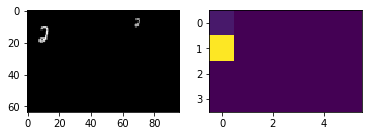

In [139]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [64, 32]
orig_im_size = 64
attn_size = [4, 2]
im_channel = 1
direction_dim = 3
n_class = 10
tensorboard_path = './tensorboard/mnist_comb_direction_soft_attn'
init_model_path = ''
demo = CombDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, 
                             save_dir, batch_size, im_size, orig_im_size, attn_size, im_channel, direction_dim, 
                             n_class, tensorboard_path, init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
# demo.test_all()
demo.visualize()

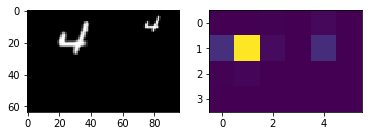

In [141]:
demo.visualize()